In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.ticker import NullFormatter
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib
import datetime
import pickle
import os
import time

In [2]:
#schema of initial data 
schema_inital_segment = 'idRequest string, deviceId string, dateTime timestamp, \
latitude double, longitude double, speedKmh Integer, heading Integer,\
accuracyDrop Integer, EngineStatus Integer, Type Integer, segmentDistance double,\
segmentDuration double, segmentSpeedKmH double'
#reading csv
path = os.path.abspath(os.getcwd())
df = spark.read.csv('file:///%s/all_merged/*'%path,sep=",", schema = schema_inital_segment)

In [16]:
df.count()

333631879

In [14]:
# dd = df.filter(df['type'] == 2)
# dd.show()
df.select('deviceId').distinct().count()

290185

22/08/31 16:51:36 ERROR cluster.YarnScheduler: Lost executor 602 on d03-bigdata.polito.it: Container container_e682_1659965092530_1190_01_000605 on host: d03-bigdata.polito.it was preempted.
22/08/31 16:51:36 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 602 for reason Container container_e682_1659965092530_1190_01_000605 on host: d03-bigdata.polito.it was preempted.


# personal ratio

In [4]:
#personal ratio
df.select("type").distinct().show()

+----+
|type|
+----+
|   1|
|   2|
+----+



In [9]:
df.filter(df['type'] == 2).count()

23367845

In [10]:
df.filter(df['type'] == 1).count()

310264034

In [7]:
ratio_personal = (df.select().where(df.Type == 1).count())/df.count()

In [8]:
ratio_personal

0.9299591961354509

In [5]:
df_personal = df.filter(df['type'] == 1)
df_personal.select('deviceId').distinct().count()

266305

<h2 style = 'color:yellow'> accuracy DROP done in "2_1-big" vasate safe

<h2 style = 'color:yellow'> daily distribution

In [17]:
dates = df.withColumn('dateTime', F.to_date('dateTime'))

In [18]:
dates.show()

+---------+--------+----------+--------+---------+--------+-------+------------+------------+----+---------------+---------------+--------------------+
|idRequest|deviceId|  dateTime|latitude|longitude|speedKmh|heading|accuracyDrop|EngineStatus|Type|segmentDistance|segmentDuration|     segmentSpeedKmH|
+---------+--------+----------+--------+---------+--------+-------+------------+------------+----+---------------+---------------+--------------------+
|        1| 2821155|2019-10-03|45.03987|   7.5624|       0|      0|           1|           1|   2|         359.56|          328.0|  3.9464142733892666|
|        1| 2822416|2019-10-02|44.96591|  7.73691|      17|    108|           1|           1|   2|        3022.67|          134.0|   81.20605142432747|
|        1| 2822416|2019-10-05|45.08456|  7.65592|      24|      4|           1|           1|   2|        1133.46|          100.0|   40.80458767741283|
|        1| 2822416|2019-10-11|45.09212|  7.67944|      20|     32|           1|        

In [19]:
dates = dates.groupby('dateTime').agg(F.count('dateTime'))

In [20]:
dates = dates.sort('dateTime')

In [21]:
dates = dates.filter(dates['dateTime'] >= '2019-01-01')

In [22]:
dates.show()

+----------+---------------+
|  dateTime|count(dateTime)|
+----------+---------------+
|2019-01-01|           1011|
|2019-01-02|           2035|
|2019-01-03|           2281|
|2019-01-04|           2732|
|2019-01-05|           2055|
|2019-01-06|           1415|
|2019-01-07|           3105|
|2019-01-08|           3464|
|2019-01-09|           3844|
|2019-01-10|           4584|
|2019-01-11|           5002|
|2019-01-12|           3734|
|2019-01-13|           5052|
|2019-01-14|         839326|
|2019-01-15|        1183122|
|2019-01-16|        1220606|
|2019-01-17|        1197046|
|2019-01-18|        1256520|
|2019-01-19|         901057|
|2019-01-20|         698288|
+----------+---------------+
only showing top 20 rows



In [24]:
dates = dates.toPandas()
dates.columns = ['date','num_segments']

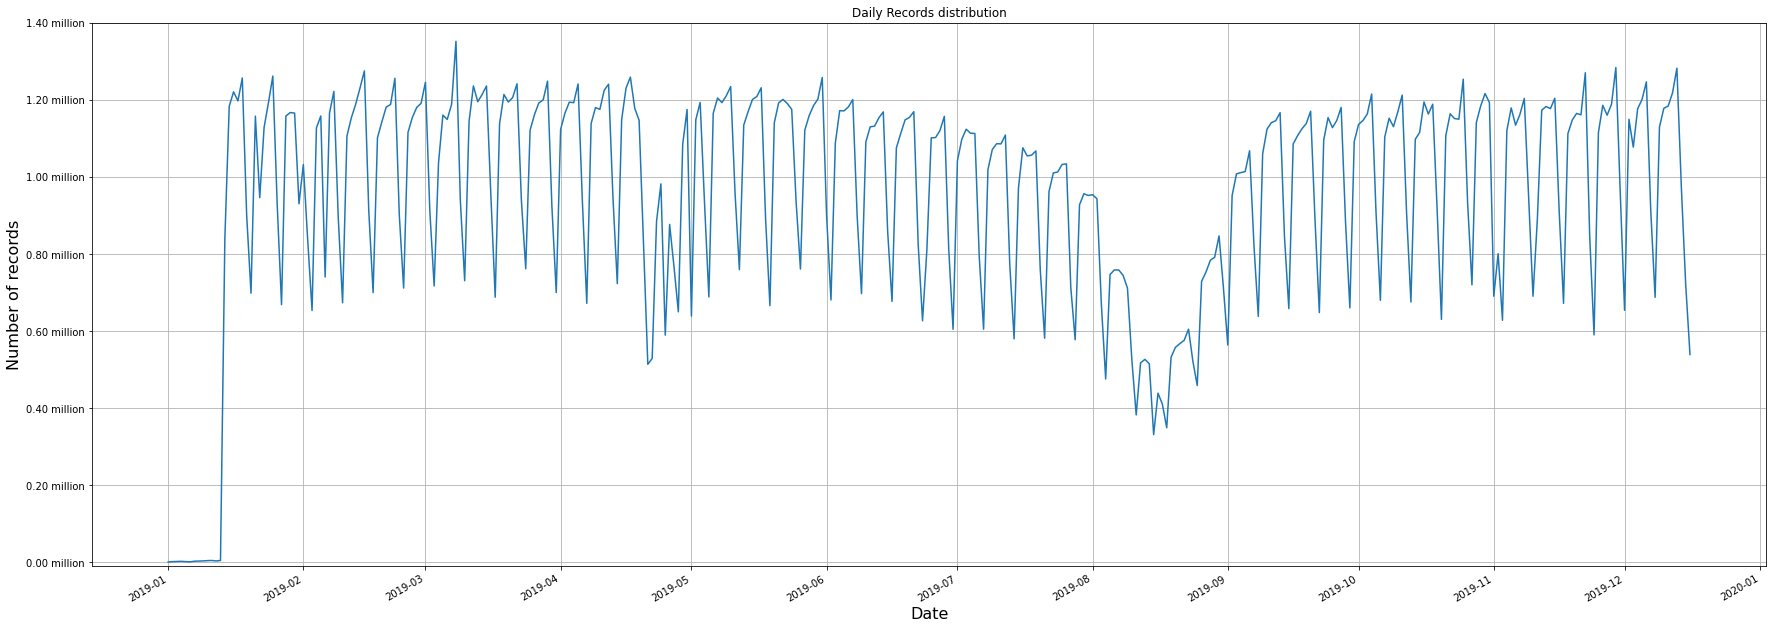

In [44]:
'''plot distribution oer dates'''
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(dates['date'],dates['num_segments'], alpha = 1)
#     plt.gca() = ax [nokte]

# locator = mdate.DayLocator()
locator = mdate.MonthLocator()
# locator = mdate.WeekLocator()
plt.gca().xaxis.set_major_locator(locator)

# plt.gca().get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
def formatter(x, pos):
    return str("{0:.2f}".format(x / 1e6)) + " million"

plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_minor_formatter(NullFormatter())
#     fig.subplots_adjust(right = 1.2)
# plt.xlim('2019-01-01')
plt.ylim(-10000,1400000)
plt.grid(True)
# plt.gca().set_axisbelow(True)
plt.xlabel("Date",fontsize=16)
plt.ylabel("Number of records", fontsize=16)
title = "Daily Records distribution"
plt.title(title)
plt.setp(plt.gca().get_xticklabels(), rotation=30, ha='right')
# plt.savefig(f'{title}.jpg',bbox_inches='tight')
plt.show()

<h2 style = 'color:yellow'> hourly distribution

In [33]:
hours = df.withColumn('dateTime', F.to_timestamp('dateTime'))

In [34]:
#change date to hour
@F.udf()
def date_to_hour(dateTime):
    hour = dateTime.hour
    return hour

hours = hours.withColumn('dateTime', date_to_hour('dateTime'))

In [35]:
hours.show()

+---------+--------+--------+--------+---------+--------+-------+------------+------------+----+---------------+---------------+--------------------+
|idRequest|deviceId|dateTime|latitude|longitude|speedKmh|heading|accuracyDrop|EngineStatus|Type|segmentDistance|segmentDuration|     segmentSpeedKmH|
+---------+--------+--------+--------+---------+--------+-------+------------+------------+----+---------------+---------------+--------------------+
|        1| 2821155|       9|45.03987|   7.5624|       0|      0|           1|           1|   2|         359.56|          328.0|  3.9464142733892666|
|        1| 2822416|      10|44.96591|  7.73691|      17|    108|           1|           1|   2|        3022.67|          134.0|   81.20605142432747|
|        1| 2822416|       3|45.08456|  7.65592|      24|      4|           1|           1|   2|        1133.46|          100.0|   40.80458767741283|
|        1| 2822416|       8|45.09212|  7.67944|      20|     32|           1|           1|   2|    

In [36]:
hours = hours.groupby(['dateTime']).agg(F.count('dateTime'))

In [38]:
hours = hours.withColumn("dateTime",hours.dateTime.cast('int'))
hours = hours.orderBy('dateTime',ascending=True)

In [39]:
hours.show()

+--------+---------------+
|dateTime|count(dateTime)|
+--------+---------------+
|       0|        7118684|
|       1|        5706893|
|       2|        3823947|
|       3|        2249255|
|       4|        1379334|
|       5|        1183521|
|       6|        1857922|
|       7|        3973490|
|       8|       10685158|
|       9|       20553155|
|      10|       22923329|
|      11|       19960885|
|      12|       19619821|
|      13|       19826790|
|      14|       18942131|
|      15|       17742813|
|      16|       18980975|
|      17|       21245350|
|      18|       24474127|
|      19|       27156574|
+--------+---------------+
only showing top 20 rows



In [40]:
hours = hours.toPandas()

In [41]:
hours.columns = ['hour','num_segment']

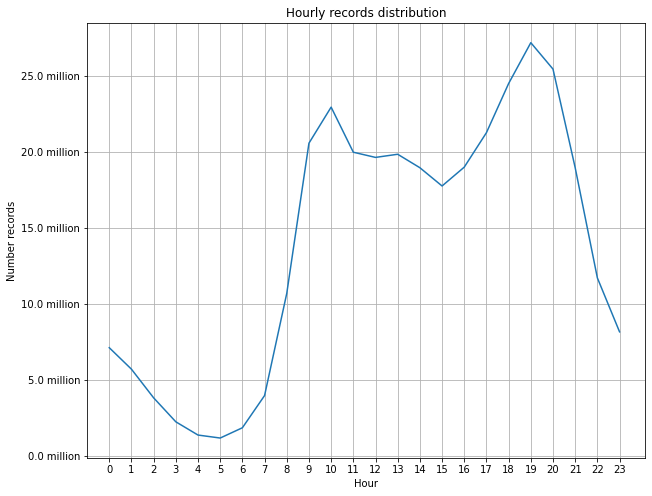

In [43]:
# df_hourly = df_hourly.toPandas()
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(hours['hour'],hours['num_segment'], alpha = 1)
#     plt.gca() = ax [nokte]
    
plt.xticks(np.arange(24))
# plt.gca().get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
def formatter(x, pos):
    return str(round(x / 1e6, 2)) + " million"

plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_minor_formatter(NullFormatter())
#     fig.subplots_adjust(right = 1.2)
plt.xlim(-1)
# plt.ylim(0,110000)
plt.grid(True)
# plt.gca().set_axisbelow(True)
plt.xlabel("Hour")
plt.ylabel("Number records")
title = "Hourly records distribution"
plt.title(title)
plt.savefig(f'{title}.jpg',bbox_inches='tight')
plt.show()

<h2 style = 'color:yellow'> different grid size chapter 3

In [2]:
#schema of segment table
schema_segments ='deviceId String,\
                  type Integer,\
                  dateTime string,\
                  startLatitude double,\
                  startLongitude double,\
                  startEngineStatus Integer,\
                  startAccuracyDrop Integer,\
                  endAccuracyDrop Integer,\
                  endEngineStatus Integer,\
                  endLatitude double,\
                  endLongitude double,\
                  segmentDistance double,\
                  segmentDuration double,\
                  segmentSpeedKmH double,\
                  xtmp double,\
                  ytmp double,\
                  start_x integer,\
                  start_y integer,\
                  end_x integer,\
                  end_y integer,\
                  cell_id_start string,\
                  cell_id_end string'
#reading csv
path = os.path.abspath(os.getcwd())
df_segments = spark.read.csv('file:///%s/segment_table'%path,sep=",", schema = schema_segments)

In [3]:
#dropping cell data columns
df_segments = df_segments.select(df_segments.columns[:14])
df_segments.show()

+--------+----+-------------------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+
|deviceId|type|           dateTime|startLatitude|startLongitude|startEngineStatus|startAccuracyDrop|endAccuracyDrop|endEngineStatus|endLatitude|endLongitude|segmentDistance|segmentDuration|   segmentSpeedKmH|
+--------+----+-------------------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+
| 2506913|   2|2019-01-14 10:10:02|      45.0721|       7.70783|                1|                1|              1|              1|   45.07185|     7.70625|         127.49|           10.0| 45.89502817963192|
| 2506913|   2|2019-01-14 10:10:12|     45.07185|       7.70625|                1|                1|              1|              1|   45.07184|     7.70514|       

In [4]:
'''adding columns related to grid table'''
schema_segments_ultimate ='deviceId String,\
                          type Integer,\
                          dateTime string,\
                          startLatitude double,\
                          startLongitude double,\
                          startEngineStatus Integer,\
                          startAccuracyDrop Integer,\
                          endAccuracyDrop Integer,\
                          endEngineStatus Integer,\
                          endLatitude double,\
                          endLongitude double,\
                          segmentDistance double,\
                          segmentDuration double,\
                          segmentSpeedKmH double,\
                          xtmp double,\
                          ytmp double,\
                          start_x integer,\
                          start_y integer,\
                          end_x integer,\
                          end_y integer,\
                          cell_id_start string,\
                          cell_id_end string'


In [62]:
means = []
durations = []

In [63]:
# ============= Torino and countryside ========================================
minLat = 44.96282106687191
minLon = 7.502048016422193
maxLat = 45.19265016665321 
maxLon = 7.791812422724604
# =============================================================================

In [100]:
'''shift by 100m in degrees'''
# shiftInMeterLat = 0.00017966305682364236 # 20m
# shiftInMeterLon = 0.0002541289066976482

# shiftInMeterLat = 0.0004491576420591059 #50m
# shiftInMeterLon = 0.0006353222667438985

# shiftInMeterLat = 0.0008983152841182118 #100m
# shiftInMeterLon = 0.001270644533487797

# shiftInMeterLat = 0.0017966305682364236 # 200m
# shiftInMeterLon = 0.002541289066976482

shiftInMeterLat = 0.0035932611364799527 # 400m
shiftInMeterLon = 0.005082578133952076

In [101]:
@F.pandas_udf(schema_segments_ultimate, functionType=F.PandasUDFType.GROUPED_MAP)
def segment_position_calculator(df_segments):
    os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "1"
    
    df_segments = df_segments.sort_values(by="dateTime")
    df_segments.reset_index(drop = True, inplace=True)
    
    '''calculating the cells that these segments belong to'''
    df_segments['xtmp'] = (df_segments['startLongitude']-minLon)/shiftInMeterLon
    df_segments['ytmp'] = (df_segments['startLatitude']-minLat)/shiftInMeterLat
    df_segments['start_x'] = (df_segments['xtmp'].apply(lambda x : np.floor(x)))+1
    df_segments['start_y'] = (df_segments['ytmp'].apply(lambda y : np.floor(y)))+1

    df_segments['xtmp'] = (df_segments['endLongitude']-minLon)/shiftInMeterLon
    df_segments['ytmp'] = (df_segments['endLatitude']-minLat)/shiftInMeterLat
    df_segments['end_x'] = (df_segments['xtmp'].apply(lambda x : np.floor(x)))+1
    df_segments['end_y'] = (df_segments['ytmp'].apply(lambda y : np.floor(y)))+1
    df_segments['cell_id_start'] = [f'{int(df_segments.start_y.values[i])}_{int(df_segments.start_x.values[i])}' 
                          for i in range(len(df_segments))]
    df_segments['cell_id_end'] = [f'{int(df_segments.end_y.values[i])}_{int(df_segments.end_x.values[i])}' 
                          for i in range(len(df_segments))]
#     df_segments = df_segments.sort_values(['id'])
    return df_segments

In [102]:
df_segment = df_segments.groupby("deviceId").apply(segment_position_calculator)

In [103]:
#average calculation
schema_grid_calculations= StructType([ 
    StructField("num_segments",IntegerType(),True)])

In [104]:
@F.pandas_udf(schema_grid_calculations, functionType=F.PandasUDFType.GROUPED_MAP)
def cell_data_calculator(df_segments):
    os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "1"
    
#     df_segments = df_segments.sort_values(by="dateTime")
    df_segments.reset_index(drop = True, inplace=True)
    
    df_data = pd.DataFrame()

    num_segments = len(df_segments)
    df_data['num_segments'] = [num_segments]
#     df_data['num_segments'] = num_segments

    
    return df_data

In [105]:
df_grid_whole = df_segment.groupby("cell_id_start" or "cell_id_end").apply(cell_data_calculator)

In [106]:
start = time.time()
a = df_grid_whole.toPandas()
end = time.time()
means.append(np.mean(a['num_segments']))
durations.append(end-start)

In [107]:
means

[399.2804240177634,
 1806.4648424364702,
 6000.267840759504,
 21595.106525016152,
 82580.6832281087]

In [108]:
durations

[302.03419065475464,
 258.3607029914856,
 234.06769609451294,
 240.73992609977722,
 296.55251359939575]

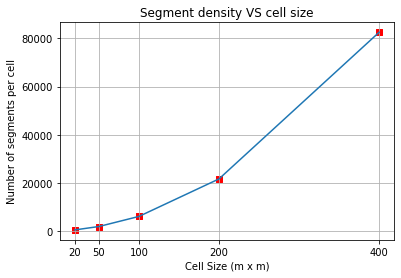

In [110]:
#plot
x = [20,50,100,200,400]
# y_time = list(df['computation duration (s)'])
# y_count = list(df['average number of segments per cell'])

plt.plot(x,means)
plt.xlabel('Cell Size (m x m)')
plt.ylabel('Number of segments per cell')
plt.title('Segment density VS cell size')
for xtemp,ytemp in zip(x,means):
    plt.scatter(xtemp, ytemp,marker='s' , color = 'red')
    # plt.vlines(xtemp, ymin=[0], ymax=ytemp, colors='red', ls='--', lw=1.5)
plt.xticks(x)
# plt.yticks(np.arange(min(y_count), max(y_count)+1, 10))
plt.grid()
plt.savefig('grid_selection_num.jpg',bbox_inches='tight')

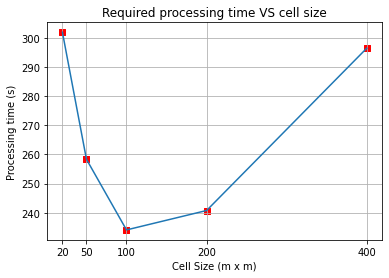

In [111]:
#plot
x = [20,50,100,200,400]
# y_time = list(df['computation duration (s)'])
# y_count = list(df['average number of segments per cell'])

plt.plot(x,durations)
plt.xlabel('Cell Size (m x m)')
plt.ylabel('Processing time (s)')
plt.title('Required processing time VS cell size')
for xtemp,ytemp in zip(x,durations):
    plt.scatter(xtemp, ytemp,marker='s' , color = 'red')
    # plt.vlines(xtemp, ymin=[0], ymax=ytemp, colors='red', ls='--', lw=1.5)
plt.xticks(x)
# plt.yticks(np.arange(min(y_count), max(y_count)+1, 10))
plt.grid()
plt.savefig('grid_selection_sec.jpg',bbox_inches='tight')